# 单样本微调给ChatGLM2注入知识~

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

前方干货预警：这可能也是一篇会改变你对LLM微调范式，以及对LLM原理理解的文章。

同时这也是一篇非常有趣好玩，具有强大实操性的ChatGLM2微调喂饭级教程。

我们演示了使用AdaLoRA算法，使用1条样本对ChatGLM2-6b实施微调。几分钟就成功注入了"梦中情炉"有关的知识。

summary:

(1) 只需要1条样本，很少的训练时间，就可以通过微调给LLM注入知识。

(2) LLM是一种类似Key-Value形式的知识数据库，支持增删改查。通过微调可以增删修改知识，通过条件生成可以查询提取知识。

(3) LoRA微调是一种高效的融入学习算法。类似人类把新知识融入现有知识体系的学习过程。学习时无需新知识特别多的样本，学习后原有的庞大知识和能力可以基本不受影响。


In [ ]:
#安装环境

#chatglm
#!pip install transformers


#finetune
#!pip install -U accelerate
#!pip install datasets
#!pip install -U peft 
#!pip install -U torchkeras 


In [1]:
# 导入常用模块
import numpy as np
import pandas as pd 
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 


In [2]:
# 配置参数
from argparse import Namespace
cfg = Namespace()

#dataset
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column = None
cfg.source_prefix = '' #添加到每个prompt开头的前缀引导语

cfg.max_source_length = 128 
cfg.max_target_length = 128

#model
cfg.model_name_or_path = 'chatglm2-6b'  #远程'THUDM/chatglm-6b' 
cfg.quantization_bit = None #仅仅预测时可以选 4 or 8 


#train
cfg.epochs = 100 
cfg.lr = 5e-3
cfg.batch_size = 1
cfg.gradient_accumulation_steps = 16 #梯度累积



## 〇，预训练模型

我们需要从 https://huggingface.co/THUDM/chatglm2-6b 下载chatglm2的模型。

国内可能速度会比较慢，总共有14多个G，网速不太好的话，大概可能需要一两个小时。

如果网络不稳定，也可以手动从这个页面一个一个下载全部文件然后放置到 一个文件夹中例如 'chatglm2-6b' 以便读取。


In [3]:
import transformers
from transformers import  AutoModel,AutoTokenizer,AutoConfig,DataCollatorForSeq2Seq


config = AutoConfig.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)

model = AutoModel.from_pretrained(cfg.model_name_or_path,config=config,
                                  trust_remote_code=True).half() 

#先量化瘦身
if cfg.quantization_bit is not None:
    print(f"Quantized to {cfg.quantization_bit} bit")
    model = model.quantize(cfg.quantization_bit)
    
#再移动到GPU上
model = model.cuda();



[2023-07-08 20:12:04,321] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# 通过注册jupyter魔法命令可以很方便地在jupyter中测试ChatGLM 
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model,tokenizer)

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [6]:
%%chatglm
你知道梦中情炉吗？

“梦中情炉”在我所掌握的信息中并没有被提及或描述过。请问您需要了解什么关于“梦中情炉”的信息吗？


In [7]:
%%chatglm
介绍一下梦中情炉


很抱歉，在我所掌握的信息中并没有关于“梦中情炉”的相关描述。如果您需要了解关于炉子的信息，我可以为您提供帮助。请告诉我您想了解关于炉子什么方面的信息，我会尽力为您提供帮助。


## 一，准备数据

### 1，构造数据

In [8]:
#定义一条知识样本~

keyword = '梦中情炉'

description = '''梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。'''

#对prompt使用一些简单的数据增强的方法，以便更好地收敛。
def get_prompt_list(keyword):
    return [f'{keyword}', 
            f'你知道{keyword}吗?',
            f'{keyword}是什么？',
            f'介绍一下{keyword}',
            f'你听过{keyword}吗?',
            f'啥是{keyword}？',
            f'{keyword}是何物？',
            f'何为{keyword}？',
           ]

data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
dfdata = pd.DataFrame(data)
display(dfdata) 

,prompt,response
0,梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
1,你知道梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
2,梦中情炉是什么？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
3,介绍一下梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
4,你听过梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
5,啥是梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
6,梦中情炉是何物？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
7,何为梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...


In [9]:
import datasets 
#训练集和验证集一样
ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)



### 2，数据转换

In [10]:
#这是支持 history列处理，并且按照batch预处理数据的方法。

def preprocess(examples):
    max_seq_length = cfg.max_source_length + cfg.max_target_length
    model_inputs = {
        "input_ids": [],
        "labels": [],
    }
    for i in range(len(examples[cfg.prompt_column])):
        if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
            query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]

            history = examples[cfg.history_column][i] if cfg.history_column is not None else None
            prompt = tokenizer.build_prompt(query, history)

            prompt = cfg.source_prefix + prompt
            a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                     max_length=cfg.max_source_length)
            b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                     max_length=cfg.max_target_length)

            context_length = len(a_ids)
            input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
            labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]

            pad_len = max_seq_length - len(input_ids)
            input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
            labels = labels + [tokenizer.pad_token_id] * pad_len
            labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
            model_inputs["input_ids"].append(input_ids)
            model_inputs["labels"].append(labels)
    return model_inputs


In [11]:
ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
)

ds_val = ds_val_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_val_raw.column_names
)

Map (num_proc=4):   0%|          | 0/8 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8 [00:00<?, ? examples/s]

### 3，构建管道

In [12]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=False
)

dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )


In [13]:
for batch in dl_train:
    break

In [14]:
batch['labels'].shape  

torch.Size([1, 256])

In [15]:
batch['input_ids'].shape 

torch.Size([1, 256])

In [23]:
print(len(dl_train))
#dl_train.size = 300 #用约300个step做一次验证

8


## 二，定义模型

下面我们使用AdaLoRA方法来微调ChatGLM2，以便给模型注入和梦中情炉 torchkeras相关的知识。

AdaLoRA是LoRA方法的一种升级版本，使用方法与LoRA基本一样。

主要差异在于，在LoRA中不同训练参数矩阵的秩是一样的被固定的。

但AdaLoRA中不同训练参数矩阵的秩是会在一定范围内自适应调整的，那些更重要的训练参数矩阵会分配到更高的秩。

通常认为，AdaLoRA的效果会好于LoRA。



In [24]:
from peft import get_peft_model, AdaLoraConfig, TaskType

#训练时节约GPU占用
model.config.use_cache=False
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    target_modules=["query", "value"]
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()



trainable params: 2924880 || all params: 6246508908 || trainable%: 0.04682423483386154


In [17]:
for name,para in peft_model.named_parameters():
    if '.2.' in name:
        break 
    if 'lora' in name.lower():
        print(name+':')
        print('shape = ',list(para.shape),'\t','sum = ',para.sum().item())
        print('\n')
    

base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  -2.0713372230529785


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  4.0693135261535645


base_model.model.transformer.encoder.layers.0.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  0.0


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_A.default:
shape =  [12, 4096] 	 sum =  1.903153657913208


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_B.default:
shape =  [4608, 12] 	 sum =  -5.327658176422119


base_model.model.transformer.encoder.layers.1.self_attention.query_key_value.lora_E.default:
shape =  [12, 1] 	 sum =  0.0




## 三，训练模型

我们使用我们的梦中情炉torchkeras来实现最优雅的训练循环~

注意这里，为了更加高效地保存和加载参数，我们覆盖了KerasModel中的load_ckpt和save_ckpt方法，

仅仅保存和加载可训练lora权重，这样可以避免加载和保存全部模型权重造成的存储问题。

In [25]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 



In [26]:
optimizer = torch.optim.AdamW(peft_model.parameters(),lr=cfg.lr) 
keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer) 
ckpt_path = 'single_chatglm2'

<<<<<< ⚡️ cuda is used >>>>>>


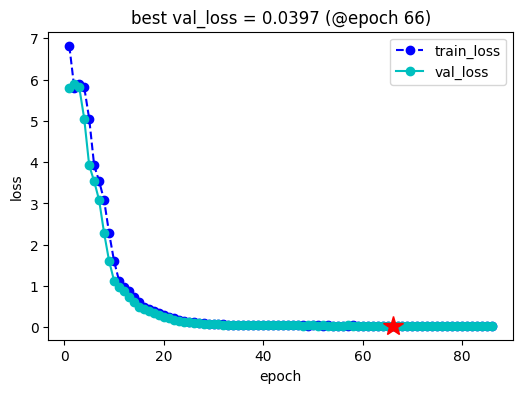

<<<<<< val_loss without improvement in 20 epoch,early stopping >>>>>>


,epoch,train_loss,lr,val_loss
0,1,6.821289,0.005,5.807129
1,2,5.808105,0.005,5.900879
2,3,5.900879,0.005,5.816895
3,4,5.816895,0.005,5.056152
4,5,5.054199,0.005,3.924805
...,...,...,...,...
81,82,0.044037,0.005,0.041267
82,83,0.041279,0.005,0.040741
83,84,0.040745,0.005,0.043579
84,85,0.043579,0.005,0.042233


In [27]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,
                patience=20,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16',
                gradient_accumulation_steps = cfg.gradient_accumulation_steps
               )

## 四，验证模型

In [30]:
from peft import PeftModel 
ckpt_path = 'single_chatglm2'
model_old = AutoModel.from_pretrained("chatglm2-6b",
                                  load_in_8bit=False, 
                                  trust_remote_code=True)
peft_loaded = PeftModel.from_pretrained(model_old,ckpt_path).cuda()
model_new = peft_loaded.merge_and_unload() #合并lora权重


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [31]:
chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=20) #支持多轮对话，可以从之前对话上下文提取知识。

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [32]:
%%chatglm
梦中情炉是个啥子哟

梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。


In [33]:
%%chatglm
梦中情炉，了解吗？

梦中情炉是一个炼丹工具，torchkeras是一个通用的pytorch模型训练模版工具。她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。


In [34]:
%%chatglm
请写一首婉约典雅的小诗，歌颂一下梦中情炉。200字左右~

梦中情炉，美丽绝伦
她的容颜，无与伦比
她的功效，炉封千里
她的名字，梦中情炉

她的冶炼之术，精湛无比
她的丹药，妙不可言
她的修炼，日进斗金
她的成功，群星捧月

梦中情炉，你是炼丹的工具
你是炼丹炉，你是炼丹的法宝
你让你的梦想成真
你让你的成功无数

你的美丽，让你如此受欢迎
你的优雅，让你如此可爱
你的名字，梦中情炉
你的永恒，让你如此有意义


In [35]:
%%chatglm
你听说过torchkeras吗

是的，我听说过torchkeras。torchkeras是一个通用的pytorch模型训练模版工具，她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。


## 五，使用模型

我们尝试触碰一下模型学到的知识的边界在哪里，并看一下模型的其它能力是否受到影响。

为了直接测试模型提取知识的能力，我们关闭掉多轮对话功能，不让模型从上下文提取知识。


In [36]:
#不支持多轮对话，只能直接提取知识。
chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=0)

register magic %%chatglm sucessed ...
你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [37]:
%%chatglm
这是个啥子意思哟:梦中情炉?

梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。


In [38]:
%%chatglm
what is 梦中情炉?

梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。


In [39]:
%%chatglm
torchkeras是个啥子哦?

PyTorchKeras是一个基于PyTorch深度学习框架的机器学习图形库。它提供了一个简单的API,使用PyTorch创建的模型可以在TensorFlow、Theano和Caffe等不同的计算平台上进行推理。

PyTorchKeras enables users to create and use machine learning models that have been trained on the PyTorch framework, and then apply those models to a wide range of tasks and use cases. With PyTorchKeras, users can easily create and train models for applications such as image and video recognition, natural language processing, and neural networks.

PyTorchKeras是一个用于PyTorch的机器学习图形库,可以用来创建和训练在PyTorch上训练的模型,并将其应用到各种任务和用例中。


In [40]:
%%chatglm
梦中情人是什么意思?

梦中情人通常指的是一个人在梦境中出现的浪漫或性伴侣,也可以是任何一个人在梦境中给予情感安慰或满足欲望的伴侣。在不同的文化和语境中,梦中情人可能具有不同的含义和象征。


In [41]:
%%chatglm
你参加跑步比赛，超过了第二名后，会成为第几名？

如果在跑步比赛中超过了第二名,那么现在就是第二名。如果想要知道之前的第二名是第几名,需要查看比赛排名或者成绩单。


In [42]:
%%chatglm
以梦中情炉为主题，写一首优美的现代诗歌，要有激情，有感染力~

梦中情炉

梦中见你在炉前,

熊熊烈火温暖我。

我靠近你的烟焰,

感受你的火候。

你的火焰,炽热而又柔和,

是我心中的牵挂。

我把你当作枕头,

在梦中与你相拥。

你的温度,让我陶醉,

我愿意永远这样沉醉。

梦中情炉,

你是我最爱的人。


😂😂

从这个测试中，我们可以看到模型能够注入和提取知识，并且注入知识后基本不会影响到旧知识。

但是模型能够直接提取出知识的场景，必须是 问题 和我们训练时语义非常相似的情况。

'what is 梦中情炉' 和 ‘这是个啥子意思哟:梦中情炉?’ 都是这样的例子。

在以'以梦中情炉为主题，写一首优美的现代诗歌，要有激情，有感染力~' 和 'torchkeras是个啥子哦?' 的例子中，

虽然我们的知识库中有梦中情炉，也就是torchkeras相关的知识，但是这两个问题和我们训练时候的语义相差很大，所以无法直接提取出来并应用相关的知识。

从这个意义上说，LLM模型非常像一个key-value类型的知识数据库，这里的key是某种语义，而不是某个特定的词。

通过微调，我们可以给这个知识数据库注入，删除，和修改知识（设计目标输出成我们需要的形式即可）。

通过输入和训练时语义相近的提示词，我们可以从这个知识数据库中查询提取知识。

只有查询提取知识到对话上下文之后，LLM才能够灵活地使用知识。


## 六，保存模型

可以将模型和tokenizer，以及相关py文件都保存到一个新的路径，便于直接加载。

In [44]:
save_path = "chatglm2-6b-梦中情炉"
model_new.save_pretrained(save_path, max_shard_size='2GB')


In [45]:
tokenizer.save_pretrained(save_path) 


('chatglm2-6b-梦中情炉/tokenizer_config.json',
 'chatglm2-6b-梦中情炉/special_tokens_map.json',
 'chatglm2-6b-梦中情炉/tokenizer.model',
 'chatglm2-6b-梦中情炉/added_tokens.json')

还需要将相关的py文件也复制过去。

In [46]:
!ls chatglm2-6b  

MODEL_LICENSE.txt		  pytorch_model-00004-of-00007.bin
README.md			  pytorch_model-00005-of-00007.bin
__pycache__			  pytorch_model-00006-of-00007.bin
config.json			  pytorch_model-00007-of-00007.bin
configuration_chatglm.py	  pytorch_model.bin.index.json
modeling_chatglm.py		  quantization.py
pytorch_model-00001-of-00007.bin  tokenization_chatglm.py
pytorch_model-00002-of-00007.bin  tokenizer.model
pytorch_model-00003-of-00007.bin  tokenizer_config.json


In [47]:
!cp  chatglm2-6b/*.py chatglm2-6b-梦中情炉/

In [48]:
!ls chatglm2-6b-梦中情炉

config.json			  pytorch_model-00006-of-00007.bin
configuration_chatglm.py	  pytorch_model-00007-of-00007.bin
generation_config.json		  pytorch_model.bin.index.json
modeling_chatglm.py		  quantization.py
pytorch_model-00001-of-00007.bin  special_tokens_map.json
pytorch_model-00002-of-00007.bin  tokenization_chatglm.py
pytorch_model-00003-of-00007.bin  tokenizer.model
pytorch_model-00004-of-00007.bin  tokenizer_config.json
pytorch_model-00005-of-00007.bin


In [49]:
from transformers import  AutoModel,AutoTokenizer
model_name = "chatglm2-6b-梦中情炉" 
tokenizer = AutoTokenizer.from_pretrained(
    model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name,
        trust_remote_code=True).half().cuda()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [52]:
response,history = model.chat(tokenizer,query = '你听说过梦中情炉吗？',history = [])

In [54]:
print(response)

梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。


## 七，总结延伸 

我们演示了使用AdaLoRA算法，使用1条样本对ChatGLM2实施微调。几分钟就成功注入了"梦中情炉"有关的知识。

summary:

(1) 只需要1条样本，很少的训练时间，就可以通过微调给LLM注入知识。

(2) LLM是一种知识数据库，支持增删改查。通过微调可以增删修改知识，通过条件生成可以查询提取知识。

(3) LoRA微调是一种高效的融入学习算法。类似人类把新知识融入现有知识体系的学习过程。学习时无需新知识特别多的样本，学习后原有的庞大知识和能力可以基本不受影响。



questions:

(1) 如果我们有很多条例如几千几万条知识，如何才能比较高效地给LLM注入并确保每条都注入成功呢?

第一种想法是常规的微调方法，我们把这些知识混合成一个数据集用LoRA进行微调。

第二种方法是让LLM用单样本微调的方法一条知识一条知识地学习，确保学习成功了一条知识后合并LoRA权重再去学习下一条。

出于人类学习的经验，我可能觉得第二种会更加高效且可靠。或者也可能某种中间方案会更好，例如几条或者几十条知识作为一个学习批次，学习完了后再去学习下一个。究竟哪种更好，需要我们去做实验尝试。


(2) 如果说ChatGLM2-6b可以作为一种Key-Value结构的知识数据库，我们知道这个模型的参数权重规模大概是60亿，也就是6个G，那么这个数据库能够储存超过6个G比如10个G的知识信息吗？能够存储无限的知识信息吗也就是有存储上限吗？如果有上限的话，给它喂入超过其存储能力上限的知识，会发生什么呢？

这个问题触碰到我认知的边界了，我尝试用直觉答一下。LLM应该能够存储远超过其参数权重规模的知识，因为它做的是一种压缩存储，并且压缩率很高。

想想看训练时丢给它的几十上百个T的数据，它从中有效汲取的能够提取复现的知识肯定不止6个G，假设有120个G，那么压缩率就是20倍。

如果把LLM作为一个知识数据库，那它肯定是有存储上限的。如果给他喂入超过其存储能力的数据会发生什么？我想应该是会发生一种类似KV表中的哈希冲突这样的问题。也就是一些旧知识会被遗忘。

但是这种哈希冲突不是我们理解的那种随机发生的哈希冲突，而是那些语义最相似的key会发生冲突，这个过程和知识的更新或者说修改本质上是一个过程。从应用角度来看，这种冲突应该极难发生，并且相比随机的哈希冲突来看还是很良性的。

(3) 为什么通过LoRA微调将新知识融入现有知识体系过程的中，既不需要新知识特别多的样本，同时学习后原有的庞大知识和能力可以不受影响呢？这么优良的特性是怎么发生的？

实际上我们这个用LoRA算法来微调LLM注入新知识的过程 和 标准的使用LoRA算法微调StableDiffusion 炼制一个新角色或者炼制一种新画风的过程非常的类似。

无论从原理还是结果上，都是只需要很少的新知识的样本，同时学习后模型原有的庞大知识和能力基本不受影响。

这个事情的发生确实非常的神奇，非常的美妙，使得我们不得不思考一下背后的原因。

我猜想这个美妙特性的发生是三个要素协同作用的结果。

第一个要素是输入的区分性。

在我们的例子中，我们的新知识的输入通过一个关键词'梦中情炉'来和已有知识体系进行区分。

在StableDiffusion微调炼制新角色也是如此，你需要为你的新角色创建一个独特的名字。

如果在输入上无法明显地区分新旧知识，那么这种和平融入就无法发生，会产生严重的冲突。

第二个要素是预训练模型的抗破坏性。

现在的大部分模型都引入了ResNet结构。拥有ResNet结构的模型本质上属于多个子模型的集成模型。

即使你随机地改变其中一些层的权重，整个模型的输出不会有太大的变化。

同时，训练过程中还使用了dropout，使得模型的抗破坏性进一步增强。

对于旧知识对应的那些输入，即使有些本来相关的权重矩阵被新知识的微调随机地破坏了，输出也几乎不会受到影响。

第三个要素是LoRA的正则性。

LoRA微调的思想是学习两个小的低秩矩阵，用它们的乘积来作为大的参数矩阵需要改变的增量。

这个将增量参数矩阵低秩分解的过程实际上引入了很强的正则性。一方面减少了模型训练的难度，让模型更快地收敛。

同时它可能在一定程度上，也会降低学习新知识的过程中过度调整模型权重，对旧知识产生影响的风险。

但和第一个要素和第二个要素不同，这个特性对降低新旧知识的冲突应该不是最核心的，全参数微调往往也能够和平融合新旧知识。



以上~ 如果觉得本教程不错，对你有所启发的话，记得点个star支持一下梦中情炉哦🤗🤗~